# Scattering

## 1. Morlet Wavelet

In [2]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
from scipy import signal, misc, ndimage
from itertools import combinations
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



In [3]:
def Morlet2D_grid(n_lines, n_columns, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """returns 2d Morlet real and imaginary filter of size (n_lines, n_columns), rotated by theta and dilated by 1/2^J"""
    X = np.arange(-n_columns / 2**(J+1), n_columns / 2**(J+1), 1/2**J) #to get n_columns length vector
    Y = np.arange(-n_lines / 2**(J+1), n_lines / 2**(J+1), 1/2**J)
    X, Y = np.meshgrid(X, Y)
    #rotate
    X_theta = np.cos(theta) * X + np.sin(theta) * Y 
    Y_theta = np.cos(theta) * Y - np.sin(theta) * X
    
    Wave = np.exp(1j * xi * (X_theta + Y_theta))
    Z_r = np.real(Wave)
    Z_i = np.imag(Wave)
    Gaus = np.exp(-np.sqrt(X_theta**2 + Y_theta**2) / (2 * sigma**2))
    Z_r *= Gaus
    Z_i *= Gaus
    
    #center Morlet wave
    Int_r = np.sum(Z_r)
    Int_i = np.sum(Z_i)
    Int_Gaus = np.sum(Gaus)

    beta_r = Int_r / Int_Gaus
    beta_i = Int_i/ Int_Gaus
    
    Z_r -= beta_r * Gaus
    Z_i -= beta_i * Gaus
    return(Z_r + 1j * Z_i)

### Representation d'une ondelette Morlet

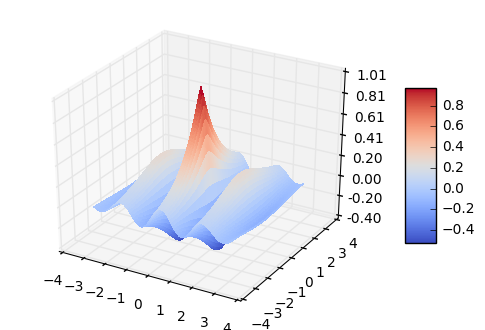

In [4]:
Z = Morlet2D_grid(100, 100, 4, theta = 3*np.pi/4)
Z_r = np.real(Z)
Z_i = np.imag(Z)
X = np.arange(-100 / 32, 100 / 32, 1/16)
Y = np.arange(-100 / 32, 100 / 32, 1/16)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z_r, rstride=1, cstride=1, cmap = cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(-0.4, 1.01)


ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Convolution 

In [10]:
def morl_conv(image, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """image of shape (n_lines, n_columns) (levels of grey not RGB), returns convolution with Morlet2D_grid"""
    morlet_filter = Morlet2D_grid(image.shape[0], image.shape[1], J, theta, sigma, xi)
    return (signal.fftconvolve(image, morlet_filter, mode = "same"))

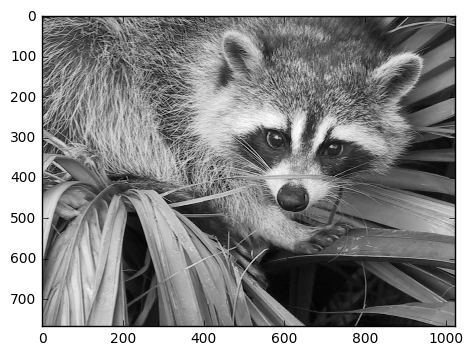

In [9]:
f = misc.face(gray = True)
plt.imshow(f, cmap=plt.cm.gray)

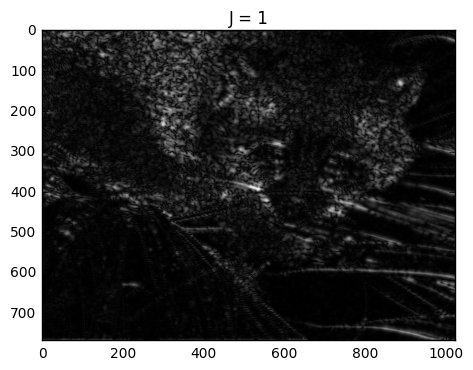

In [11]:
fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
f2 = morl_conv(f, J = 1, theta = np.pi/3)
f2 = np.abs(f2)
plt.imshow(f2, cmap = plt.cm.gray)
a.set_title("J = 1")

[ 177.48817255  232.05433404  282.24175336 ...,  239.6773566   232.94761204
  220.58679791]
[ 170.00921164  230.31988854  280.68806259 ...,  238.68223644  232.34160408
  217.13113238]


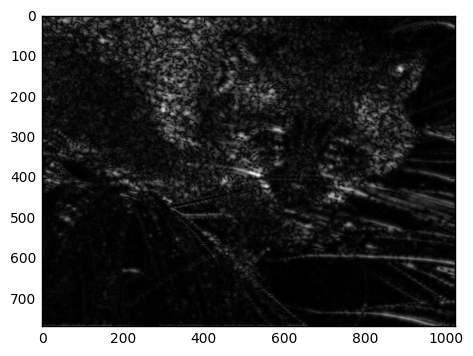

In [12]:
f3 = ndimage.filters.gaussian_filter(f2, 1/2)
plt.imshow(f3, cmap = plt.cm.gray)
print(f3[0, :])
print(f2[0, :])

## Computing Scattering coeffs

In [16]:
def cascade_wavelet_transf(image, j_path, theta_path):
    """js_path is the dilatations 2**-j we want to compute, thetas_path is similarly thetas path for the rotations 
    returns U[p]: see Mallat article """
    U = image.copy()
    for j, theta in zip(j_path, theta_path):
        U = np.abs(morl_conv(U, J = j, theta = theta))
    return U
        
            

In [17]:
def scattering_paths(J, m, K):
    """ returns a list of all paths = [(j_path, theta_path)] of length M with j_path[k]<j_path[k+1]<= J
        and theta = 2 * np.pi * k, k < K"""
    thetas = [2 * np.pi * k / K for k in range(K)]
    js_path = [list(comb) for comb in combinations(range(1, J + 1), m)]
    thetas_paths = [[theta] for theta in thetas]
    scat_path = []
    for i in range(m - 1):
        new_th_paths = []
        for j in range(len(thetas_paths)):
            for theta in thetas:
                new_th_paths.append(thetas_paths[j] + [theta])
        thetas_paths = new_th_paths
    for j_path in js_path:
        for th_path in thetas_paths:
            scat_path.append((j_path, th_path))
    return scat_path

In [27]:
def scatter_coeffs_long(image, m, K, J = 0, alpha = 1/2):
    
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations
    too long"""
    if J == 0:
        J = int(math.log(image.shape[0], 2))
    scat_coeffs = {}
    for i in range(1, m + 1):
        scat_coeffs[i] = []
        for path in scattering_paths(J, i, K):
            U_path = cascade_wavelet_transf(image, path[0], path[1])
            S_U_path = 1/2**J*ndimage.filters.gaussian_filter(U_path, 1/2**J)
            scat_coeffs[i].append(S_U_path) #vérifier que c'est toujous les mêmes
    print(len(scat_coeffs[2]))
    return scat_coeffs
            

In [22]:
f_for_scat = f[300 : 328, 500 : 528]

In [28]:
%lprun -f morl_conv scatter_coeffs_long(f_for_scat, 2, 8)

384
